# Multiclass Classifier: Random Forest. Confusion Matrix  - 14-June-2017
----------------------------
## Summary
1. Random Forest: OOB rates for different number of estimators
2. Random Forest: Confusion Matrix
3. Clustering using K-means: selecting number of clusters 
4. Clusters graphs + Rand index  
----------------------------

#### Imports 

In [1]:
%matplotlib inline
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn import neighbors

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### Helper functions

In [2]:
# get data from the data file
def get_data(data_dict, data_id):
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file')
    df = pd.read_csv(file_name, index_col = 0)
    data = df.iloc[:,1:]
    target = df.fall
    return data_name, data, target

#gets data for a specific activity
def get_data_by_activity(data_dict, data_id, test_dict, activity_id):
    # read in data
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file')
    df = pd.read_csv(file_name, index_col = 0)
    # join with activity data 
    df = df.join(test_dict[['activity_id']])
    # select required activity and all falls
    data = df[ (df.activity_id == activity_id) | df.fall == 1]
    # get data and target 
    target = data['fall']
    data = data.drop(['fall','activity_id'], axis = 1)
    # get activity name
    dd = test_dict[test_dict.activity_id == activity_id].head(1)
    activity_name = dd.iloc[0,1]
    data_name = activity_name
    return data_name, data, target

# gets data with multiclass target
def get_data_multiclass(data_dict, data_id, test_dict):
    # read in data
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file')
    df = pd.read_csv(file_name, index_col = 0)
    # join with activity data 
    df = df.join(test_dict[['activity_id']])
    # for all falls ( i.e. with activity_id > = 9) set activity_id = 9 as a class label
    df.loc[df.activity_id > 9,'activity_id'] = 9
    # get data and target 
    target = df['activity_id']
    data = df.drop(['fall','activity_id'], axis = 1)
    return data_name, data, target

# normalises train data set as (X - mean / stdev) and applies the same scaling to test dataset 
def train_test_normalise(x_train, x_test):
    mean = x_train.mean().T
    std = x_train.std().T
    return ((x_train - mean)/std,(x_test - mean)/std) 

# returns model metrics for training and test sets
def model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='', data_name='', info=''):
    result = pd.DataFrame({'classifier': clf_name,
                           'data_set': data_name,
                           'num_feat': X_train.shape[1],  
                           'info': info,
                           'train_accuracy': metrics.accuracy_score(y_train, clf.predict(X_train)), 
                           'train_precision': metrics.precision_score(y_train, clf.predict(X_train)), 
                           'train_recall': metrics.recall_score(y_train, clf.predict(X_train)),
                           'test_accuracy': metrics.accuracy_score(y_test, clf.predict(X_test)), 
                           'test_precision': metrics.precision_score(y_test, clf.predict(X_test)), 
                           'test_recall': metrics.recall_score(y_test, clf.predict(X_test)),
                          },
                          index = [0])
    columns = ['classifier','data_set','num_feat','test_accuracy','test_precision','test_recall',
              'train_accuracy','train_precision','train_recall','info']
    result = result[columns]
    return result                                                                   

#### Read in data dictionary for available datasets

In [3]:
data_dict = pd.read_csv('data/data_dict.csv', index_col = 0)
data_dict

,name,desc,num_features,file,normalise
id,,,,,
1,magn_stats,Summary statistics on acceleration magnitude,8,data/magn_stats.csv,1
2,triax_stats,Summary statistics on triaxial acceleration,24,data/triax_stats.csv,1
3,magn_ts,Time series of acceleration magnitude,51,data/magn_ts.csv,0
4,triax_ts,Time series of triaxial accelaration - raw data,153,data/triax_ts.csv,0


In [4]:
test_dict = pd.read_csv('data/test_dict.csv')
test_dict = test_dict.set_index('test_id')
test_dict['subtype'].value_counts()

FALL            1699
running         1673
walking         1021
going_down       707
going_up         651
jumping          445
lying_down       260
getting_up       218
sitting_down     180
standing_up      159
Name: subtype, dtype: int64

In [5]:
# build activities dictionary
activity_dict = test_dict.drop_duplicates()
activity_dict = activity_dict.set_index('activity_id')
# get class names
class_names = np.array(activity_dict.iloc[0:10,:]['subtype'])
class_names

array(['standing_up', 'getting_up', 'walking', 'running', 'going_up',
       'jumping', 'going_down', 'lying_down', 'sitting_down', 'FALL'], dtype=object)

--------------------
## Random forest

In [6]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

### Random forest - OOB error rates 

/Users/annazamaraeva/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


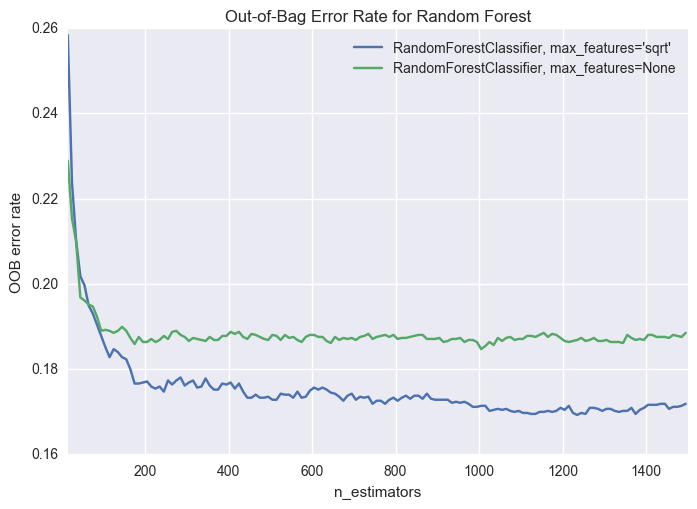

In [7]:
# run multiclass random forest on traxial statistics data
data_id = 2
data_name, data, target = get_data_multiclass(data_dict,data_id,test_dict)
need_normalise = data_dict.get_value(data_id,'normalise') 

#split into training and test and normalise if required
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
if (need_normalise == 1): 
    X_train, X_test = train_test_normalise(X_train, X_test)


RANDOM_STATE = 13

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)) ,
 #   ("RandomForestClassifier, max_features='log2'",
 #       RandomForestClassifier(warm_start=True, max_features='log2',
 #                              oob_score=True,
 #                              random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 1500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1,10):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.title('Out-of-Bag Error Rate for Random Forest');

### Confusion Matrix for Random Forest 1

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1100, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Accuracy - Train set:  1.0
Accuracy - Test set:  0.84034212402


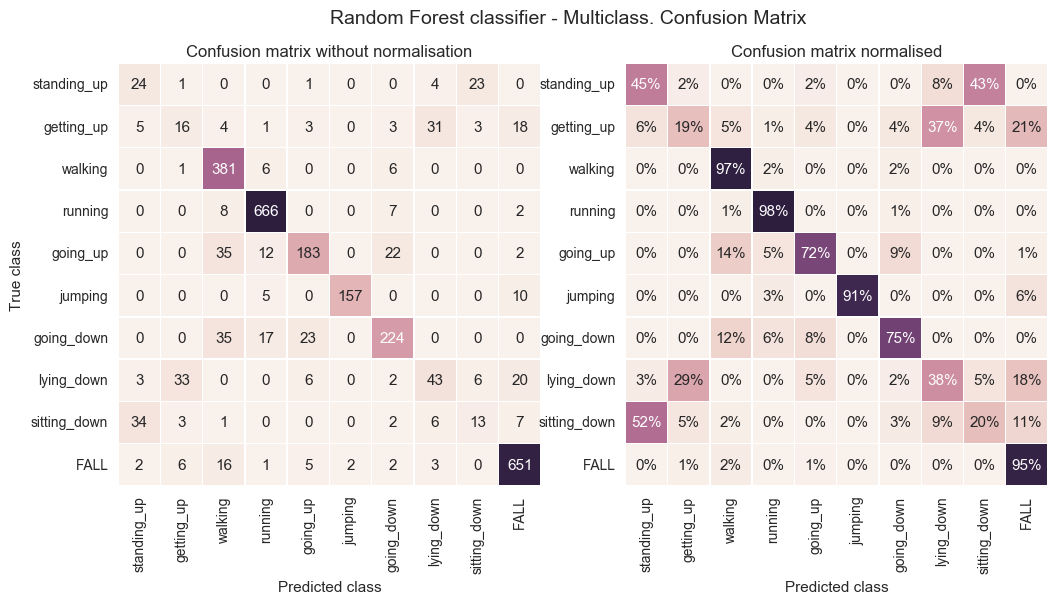

In [8]:
# run multiclass random forest on traxial statistics data
data_id = 2
data_name, data, target = get_data_multiclass(data_dict,data_id,test_dict)
need_normalise = data_dict.get_value(data_id,'normalise') 

#split into training and test and normalise if required
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
if (need_normalise == 1): 
    X_train, X_test = train_test_normalise(X_train, X_test)

#train classifier
clf = RandomForestClassifier(max_features='log2',n_estimators =1100)
clf.fit(X_train, y_train)
print clf
print 'Accuracy - Train set: ' , metrics.accuracy_score(y_train, clf.predict(X_train))
print 'Accuracy - Test set: ' , metrics.accuracy_score(y_test, clf.predict(X_test))

# get confusion matrix 
conf_matrix = metrics.confusion_matrix(y_test, clf.predict(X_test))
conf_matrix = pd.DataFrame(conf_matrix,columns = class_names, index = class_names)
# normalise confusion matrix
conf_matrix_norm = conf_matrix.divide(conf_matrix.sum(axis = 1),axis = 0)

# plot confusion matrices
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
sns.heatmap(conf_matrix,annot=True, fmt="d",cbar=False,linewidths=.3, square = True, annot_kws={"size": 11}, ax = ax1);
ax1.set_title('Confusion matrix without normalisation',fontsize=12)
ax1.set_xlabel('Predicted class')
ax1.set_ylabel('True class');
sns.heatmap(conf_matrix_norm,annot=True, fmt = '.0%', cbar=False,linewidths=.3,annot_kws={"size": 11}, square = True, ax = ax2);
ax2.set_title('Confusion matrix normalised',fontsize=12);
ax2.set_xlabel('Predicted class')
plt.subplots_adjust(wspace=0.2,top = 0.95)
plt.suptitle('Random Forest classifier - Multiclass. Confusion Matrix',fontsize=14);

----------------------------------------
## Clustering 

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [10]:
# run K means clustering on traxial statistics data
data_id = 2
data_name, data, labels_twoclass = get_data(data_dict,data_id)
data_name, data, labels_multiclass = get_data_multiclass(data_dict,data_id,test_dict)

need_normalise = data_dict.get_value(data_id,'normalise')
if (need_normalise == 1): 
    X_train, X_test = train_test_normalise(X_train, X_test)

### Choosing number of clusters using Elbow curve

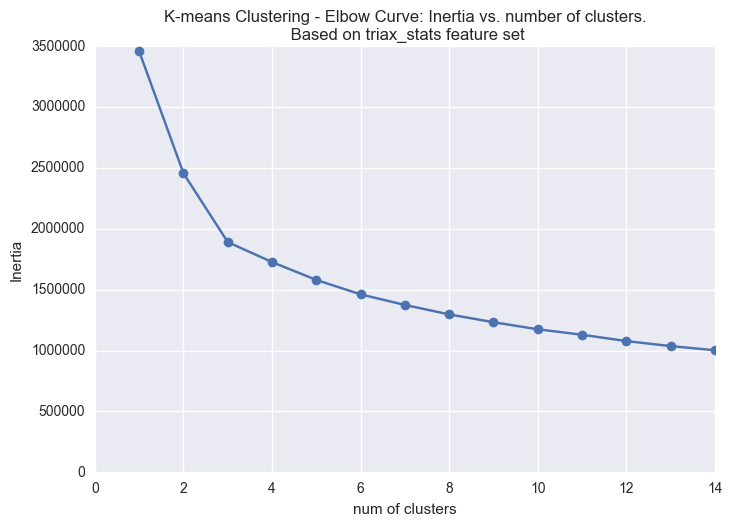

In [11]:
#try k in the range of 1 to 12 and caluclate inertia (intra-cluster sum of squared distances to the centroids)
k_range = range(1,15)
inertia = [KMeans(n_clusters=k,random_state = 13).fit(data).inertia_ for k in k_range]

#plot an elbow chart
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, inertia, '-o')
ax.set_ylim(0,3500000)
ax.set_title('K-means Clustering - Elbow Curve: Inertia vs. number of clusters.\n Based on %s feature set' %data_name)
ax.set_xlabel('num of clusters')
ax.set_ylabel('Inertia');

It seems that there are 3 clusters ?  ( the curve starts to decay slower after k = 3) 

### Choosing number of clusters using silhouette anal|sis

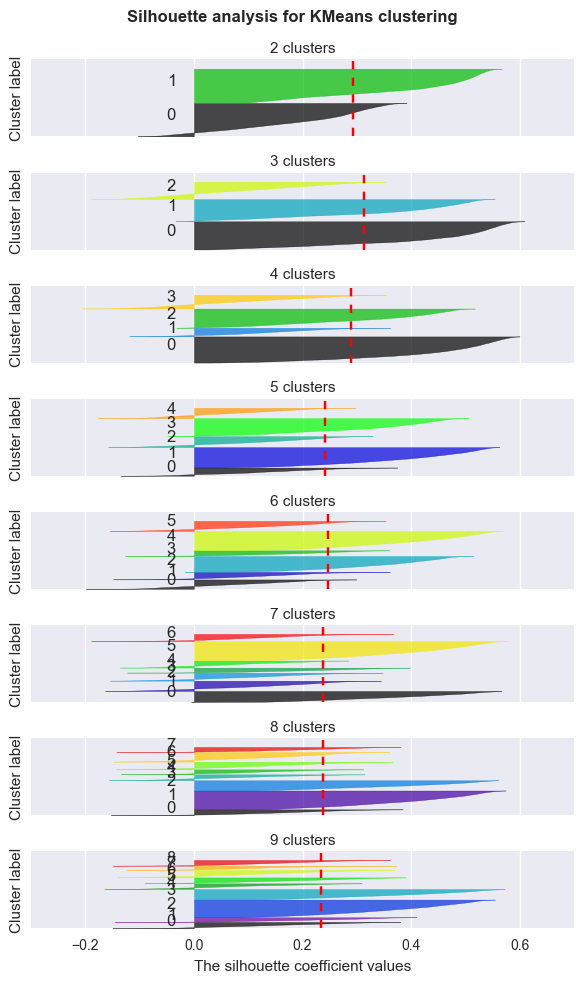

In [12]:
range_n_clusters = range(2,10)

fig, ax = plt.subplots(len(range_n_clusters), 1, sharex=True, figsize = (6,10))
plot_count = 0
for n_clusters in range_n_clusters:
    # calculate clusters
    clusterer = KMeans(n_clusters=n_clusters, random_state=21)
    cluster_labels = clusterer.fit_predict(data)
    # compute average silhouette_score
    silhouette_avg = silhouette_score(data, cluster_labels)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax[plot_count].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax[plot_count].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax[plot_count].set_title("%d clusters" % n_clusters,fontsize=11)
    ax[plot_count].set_ylabel("Cluster label",fontsize=11)

    # The vertical line for average silhouette score of all the values
    ax[plot_count].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax[plot_count].set_yticks([])  
    plot_count = plot_count + 1

# Decorate plot    
ax[plot_count-1].set_xlabel("The silhouette coefficient values");
fig.tight_layout()
fig.subplots_adjust(top= 0.93)
plt.suptitle("Silhouette analysis for KMeans clustering",fontsize=12, fontweight='bold');

When using 3 clusters , the average silhoutte score is at maximum. So this also seems to suggest that there are 3 clusters.. 

### Visualising clusters

In [13]:
# Project the original data into first two Principal Components 
data_transformed = pd.DataFrame(PCA(n_components=2).fit_transform(data), columns = ['PC1', 'PC2'])

Rand index:  0.106960446155
Adjusted Mutual Information:  0.107512904038
Confusion Matrix
[[2061 3253]
 [1401  298]]


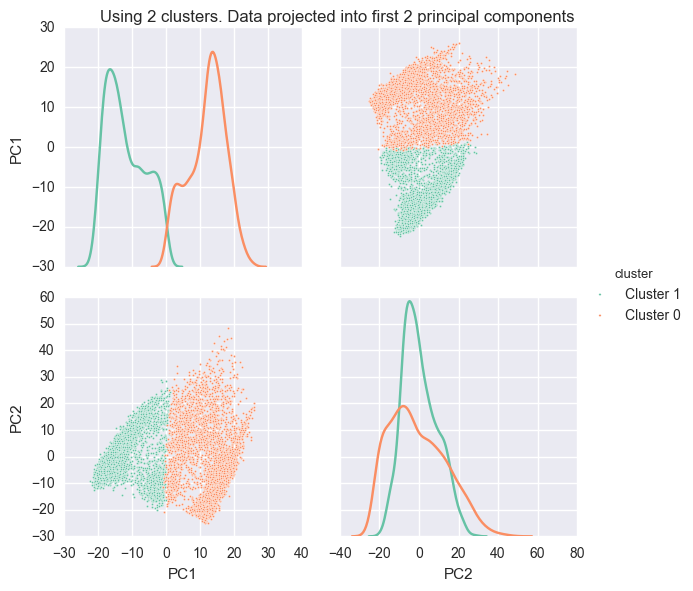

In [14]:
# assign clusters 
n_clusters = 2
labels_pred = KMeans(n_clusters = n_clusters,random_state = 13).fit_predict(data)
data_new = data_transformed
data_new['cluster'] = labels_pred
data_new['cluster'] = "Cluster " + data_new['cluster'].apply(str)

#plot distributions
g = sns.pairplot(data_new, hue="cluster", diag_kind="kde",size=3,plot_kws={"s": 3},palette='Set2')
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Using %d clusters. Data projected into first 2 principal components' %n_clusters)

# calculate Similarity measures for true labels and clusters
print 'Rand index: ', metrics.adjusted_rand_score(labels_twoclass, labels_pred)
print 'Adjusted Mutual Information: ', metrics.adjusted_mutual_info_score(labels_twoclass, labels_pred) 
print 'Confusion Matrix\n', metrics.confusion_matrix(labels_twoclass, labels_pred)

Adjusted Rand index, two class:  0.239201209856
Adjusted Mutual Information, two class:  0.196142988393
Confusion Matrix Multiclass
[[   1   86   72    0    0    0    0    0    0    0]
 [   1  121   96    0    0    0    0    0    0    0]
 [   2  554  465    0    0    0    0    0    0    0]
 [ 328  794  551    0    0    0    0    0    0    0]
 [  12  372  267    0    0    0    0    0    0    0]
 [ 126  174  145    0    0    0    0    0    0    0]
 [   9  438  260    0    0    0    0    0    0    0]
 [   3  136  121    0    0    0    0    0    0    0]
 [   2  103   75    0    0    0    0    0    0    0]
 [1311  144  244    0    0    0    0    0    0    0]]


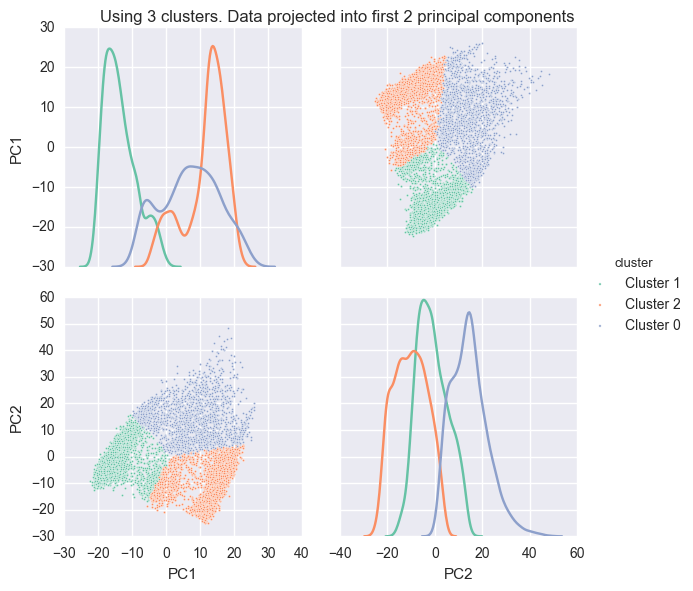

In [15]:
# assign clusters 
n_clusters = 3
labels_pred = KMeans(n_clusters = n_clusters,random_state = 13).fit_predict(data)

data_new = data_transformed
data_new['cluster'] = labels_pred
data_new['cluster'] = "Cluster " + data_new['cluster'].apply(str)

#plot distributions
g = sns.pairplot(data_new, hue="cluster", diag_kind="kde",size=3,plot_kws={"s": 3},palette='Set2')
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Using %d clusters. Data projected into first 2 principal components' %n_clusters)

# calculate Rand index
print 'Adjusted Rand index, two class: ', metrics.adjusted_rand_score(labels_twoclass, labels_pred) 
print 'Adjusted Mutual Information, two class: ', metrics.adjusted_mutual_info_score(labels_twoclass, labels_pred)  
print 'Confusion Matrix Multiclass\n', metrics.confusion_matrix(labels_multiclass, labels_pred)

Adjusted Rand index, multi class:  0.131019629361
Adjusted Mutual Information, multi class:  0.270467829608
Confusion Matrix Multiclass
[[  0   7  22   7  42   3   1   0   4  73]
 [  6   1  55   9  51   7   1   0   1  87]
 [  0  31  11 408 507   0  53   0  11   0]
 [ 84 376   6 143 291   0 432  19 322   0]
 [  2  18  28 222 327   1  24   0  28   1]
 [ 38  95   4  21  70   2 104  12  97   2]
 [  3  21  28 205 382   0  43   0  24   1]
 [  4   1  72  22  50   5   2   0   3 101]
 [  4   5  33   7  42   1   1   0   2  85]
 [316  54  66  33  18 411 108 408 162 123]]


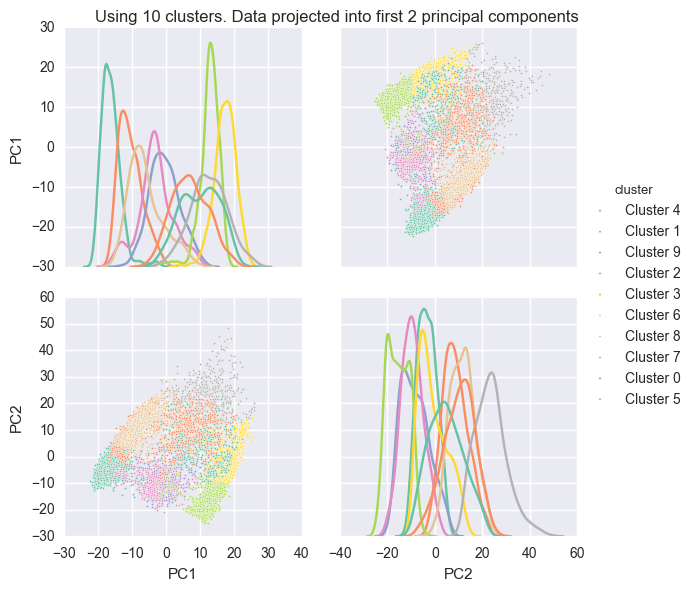

In [16]:
n_clusters = 10
labels_pred = KMeans(n_clusters = n_clusters,random_state = 13).fit_predict(data)

data_new = data_transformed
data_new['cluster'] = labels_pred
data_new['cluster'] = "Cluster " + data_new['cluster'].apply(str)

#plot distributions
g = sns.pairplot(data_new, hue="cluster", diag_kind="kde",size=3,plot_kws={"s": 3},palette='Set2')
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Using %d clusters. Data projected into first 2 principal components' %n_clusters)

# calculate Rand index
print 'Adjusted Rand index, multi class: ', metrics.adjusted_rand_score(labels_multiclass, labels_pred) 
print 'Adjusted Mutual Information, multi class: ', metrics.adjusted_mutual_info_score(labels_multiclass, labels_pred)
print 'Confusion Matrix Multiclass\n', metrics.confusion_matrix(labels_multiclass, labels_pred)